<a href="https://colab.research.google.com/github/onlygoodman/MLDLpractice/blob/master/project_cfr014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"Isolation Forest" 모델 사용
001 feature 골라서 사용하면서 + pca 사용하여 최고점수 도출시도

002 코사인, 피어슨 유사도 특성추가

003 -

004 Isolation Forest가 Robust모델에 비해 f1, auc 스코어 간의 격차가 적어 hyperparameter값 세부조정 시도

- Isolation Forest h-params는 nes=150근처 pca는 사용하지 않을 때 성능이 가장 좋았다. -> 최대한 독립적인 특성만 사용하면서 학습시켰기 때문이라고 생각

005 성능 개선을 위해서는 특성추가가 필요하다고 생각 11, 12, 17에서
2, 4, 9, 10, 11, 12, 16, 17, 18 으로 특성 늘려서 학습

006 4,9번특성이 성능이 잘나와서 4,9,11,12,17,31,32 특성을 사용하고 LOF와 OCS 모델 추가 사용하여 학습

008 코사인유사도, 피어슨유사도, 11,12,17번을 사용하고 robust 모델의 성능이 개선되는 feature을 도출해내는 과정

009 - 008의 실험결과가 14번이 생각이상으로 좋은 특성이었던것 같고 [29, 28, 27, 23, 21, 20, 8, 7, 5, 2]가 모델 성능을 현저히 떨어트리는 특성인것같다. 해당 특성을 제외하고 코사인, 피어슨 유사도를 측정 11,12,14,17,31,32 로 학습한 결과와 비교

010 - 009에서 14번 추가 후 성능상승, 1번부터 다시 최적의 특성탐색

011 - 3 10 13 26 30 번특성 추가 후 1버부터 다시 최적의 특성탐색

012 - 11번 최적의 탐색 결과를 바탕으로 train data target값 얻은 후 svc model 을통해 일반화시도

013 --

014 - 17 14 12 10 7 3 16 11 4 5 1 9 2 18 6 27 8 19 28 22 20 30 24 15 26 23 25 13 29 21 순으로 feature 의 코사인유사도 구하고 feature을 하나씩 증가시키면서 f1socre의 변화 확인 점수화 하여 그래프로 그리고 최적의 feature사용 시도



In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from itertools import permutations,combinations

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")


import math #차후 factorial 계산 등 수학적인 계산을 위한 import
from numpy import dot
from numpy.linalg import norm

from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures #특성공학을 사용하기 위한 import
from sklearn.preprocessing import StandardScaler #전처리된 데이터들의 scale을 맞춰주기 위한 import
from sklearn.decomposition import PCA #차원 축소 - 주성분의 개수에 따른 최적화 모델 구현을 위한 import


#model
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
# from sklearn.cluster import AgglomerativeClustering


from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score #이후 test.csv 파일의 predict 자료의 score을 매기기 위한 import

In [2]:
# Train dataset은 Label이 존재하지 않음
train_df = pd.read_csv("/content/drive/MyDrive/ai7/train.csv")
save_df = pd.read_csv("/content/drive/MyDrive/ai7/train.csv")
val_df  = pd.read_csv("/content/drive/MyDrive/ai7/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/ai7/test.csv")
submit = pd.read_csv("/content/drive/MyDrive/ai7/sample_submission.csv")

In [3]:
clist = list(train_df.columns)
print(clist)

train_data = train_df[clist[1:]].to_numpy()
val_data = val_df[clist[1:]].to_numpy()
val_target = val_df['Class'].to_numpy()

print(val_target)

valcount1=0
valcountm1=0
for i in val_target:
  if i==1:
    valcount1+=1
  else:
    valcountm1+=1

print(valcount1, valcountm1)

outliers_fraction = valcount1/valcountm1
print("outliers_fraction =",outliers_fraction)

['ID', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30']
[0 0 0 ... 0 0 0]
30 28432
outliers_fraction = 0.0010551491277433877


코사인유사도 구하기

피어슨유사도 구하기

In [7]:
def cos_sim(a, b):
  return dot(a, b)/(norm(a)*norm(b))

def cosfeature(data):
  datacs=[]
  for i in data[col].to_numpy():
    datacs.append(cos_sim(abnor_vector, i))
  data['V31']=datacs

def predata(data):
  return data.drop(columns=['ID'])[col]

def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred


testnum=1
maxscore=0
auc_scoreboard=[]
f1__scoreboard=[]


## 코사인 유사도 추가 section
ff = "17 14 12 10 7 3 16 11 4 5 1 9 2 18 6 27 8 19 28 22 20 30 24 15 26 23 25 13 29 21"
featureimportance=list(map(int, ff.split()))

# col = [clist[i] for i in range(1, 30+1) if i!=29] #유사도를 구할 때 사용 할 특성
for i in range(30,20,-1):
  col = [clist[featureimportance[i]] for i in range(0, i) ]
  coscol = col

  val_abnor = val_df[val_df['Class']==1][col]
  abnor_vector = val_abnor.mean().to_numpy()

  cosfeature(train_df)
  cosfeature(val_df)
  cosfeature(test_df)

  clist = list(train_df.columns)
  testname="010"

  for j in range(1, 15+1):
    mainfeature = [featureimportance[j] for j in range(0, j) ]
    col = [clist[k] for k in mainfeature+[31]]
    maincol = col

    train_x = predata(train_df)
    val_x = predata(val_df) # Input Data
    val_y = val_df['Class'] # Label

    test_x = predata(test_df)

    ss = StandardScaler()
    ss.fit(train_x)
    train_pca = ss.transform(train_x)
    val_pca = ss.transform(val_x)
    test_pca = ss.transform(test_x)

    model_if = 0
    model_rc = EllipticEnvelope(contamination=outliers_fraction)
    model_list=[("IF", model_if), ("RC", model_rc)]#,("LOF", model_lof),("OCS", model_ocs)]

    for name, m in model_list[1:]:

      m.fit(train_pca)
      val_pred = m.predict(val_pca)
      val_pred = get_pred_label(val_pred)
      val_score = f1_score(val_y, val_pred, average='macro')
      val_auc_score = roc_auc_score(val_y, val_pred)
      print("no.{:0>4} model_{}\t------------------max-{}".format(testnum, name, maxscore))
      print("cosifeature : {}".format(coscol))
      print("mainfeature : {}".format(col))
      testnum+=1

      if val_score>maxscore:
        maxscore=val_score

      f1__scoreboard.append([len(coscol),len(maincol),val_score])
      auc_scoreboard.append([len(coscol),len(maincol),val_auc_score])

      print('f1-score : {:.4f},\t\tauc-score : {:.4f}'.format(val_score*100, val_auc_score*100))      
      print()



      # train_pred = m.predict(train_pca) #train prediction
      # train_y = get_pred_label(train_pred)
      # save_df['Class'] = train_y

      # test_pred = m.predict(test_pca) # model prediction  
      # test_pred = get_pred_label(test_pred)
      # submit['Class'] = test_pred
      # submit.to_csv('./submit{}_no.{:0>4}_model_{}.csv'.format(testname, testnum, name), index=False)


no.0001 model_RC	------------------max-0
cosifeature : ['V17', 'V14', 'V12', 'V10', 'V7', 'V3', 'V16', 'V11', 'V4', 'V5', 'V1', 'V9', 'V2', 'V18', 'V6', 'V27', 'V8', 'V19', 'V28', 'V22', 'V20', 'V30', 'V24', 'V15', 'V26', 'V23', 'V25', 'V13', 'V29', 'V21']
mainfeature : ['V17', 'V31']
f1-score : 87.4877,		auc-score : 84.9912

no.0002 model_RC	------------------max-0.8748769079271295
cosifeature : ['V17', 'V14', 'V12', 'V10', 'V7', 'V3', 'V16', 'V11', 'V4', 'V5', 'V1', 'V9', 'V2', 'V18', 'V6', 'V27', 'V8', 'V19', 'V28', 'V22', 'V20', 'V30', 'V24', 'V15', 'V26', 'V23', 'V25', 'V13', 'V29', 'V21']
mainfeature : ['V17', 'V14', 'V31']
f1-score : 93.0964,		auc-score : 91.6614

no.0003 model_RC	------------------max-0.9309641419574388
cosifeature : ['V17', 'V14', 'V12', 'V10', 'V7', 'V3', 'V16', 'V11', 'V4', 'V5', 'V1', 'V9', 'V2', 'V18', 'V6', 'V27', 'V8', 'V19', 'V28', 'V22', 'V20', 'V30', 'V24', 'V15', 'V26', 'V23', 'V25', 'V13', 'V29', 'V21']
mainfeature : ['V17', 'V14', 'V12', 'V31']
f1-

In [6]:
print(featureimportance)

[17, 14, 12, 10, 7, 3, 16, 11, 4, 5, 1, 9, 2, 18, 6, 27, 8, 19, 28, 22, 20, 30, 24, 15, 26, 23, 25, 13, 29, 21]


In [ ]:
# #얻어낸 target값을 통해 train_input, train_target을 SVC 모델에 사용


# train_x= train_pca
# train_y= save_df['Class'].to_numpy()
# no = "003"
# ker='poly'
# svm = SVC(kernel=ker, degree=2, C=1.0, gamma=5) 
# knn = KNeighborsClassifier(n_neighbors=5)

# # svm = SVC(kernel = ker, C=5)
# svm.fit(train_x, train_y)
# knn.fit(train_x, train_y)

# testname = "_{}".format(ker+no)


# # model prediction  
# test_pred2 = svm.predict(test_pca)
# test_pred3 = knn.predict(test_pca)
# submit['Class'] = test_pred2
# # submit.to_csv('./submit{}_model_SVC.csv'.format(testname, name), index=False)    

# submit['Class'] = test_pred3
# # submit.to_csv('./submit{}_model_KNN.csv'.format(testname, name), index=False)



SVC model apply before & after
before


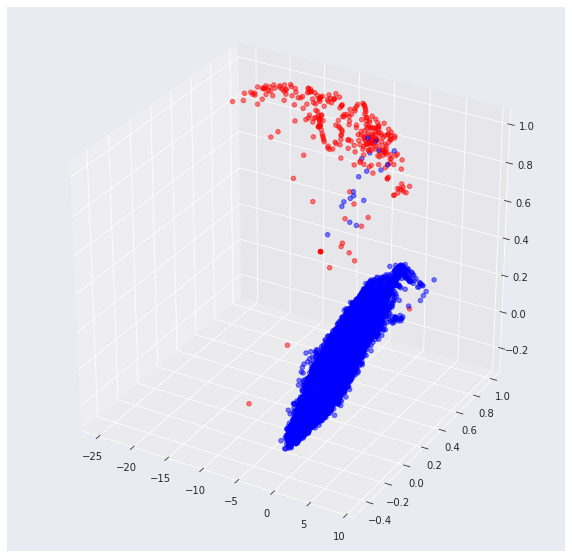


SVC


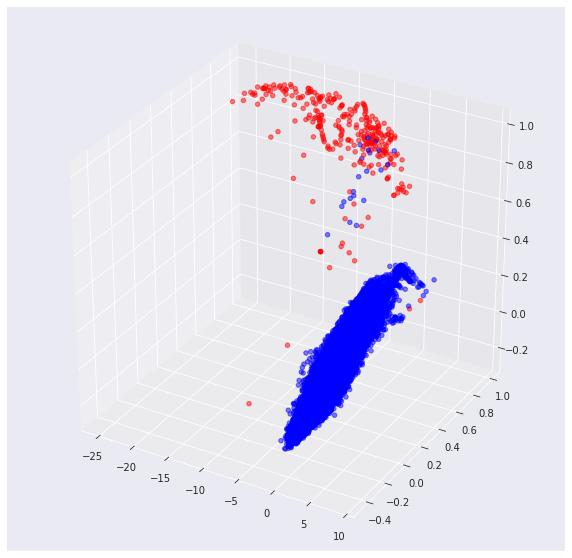


KNN


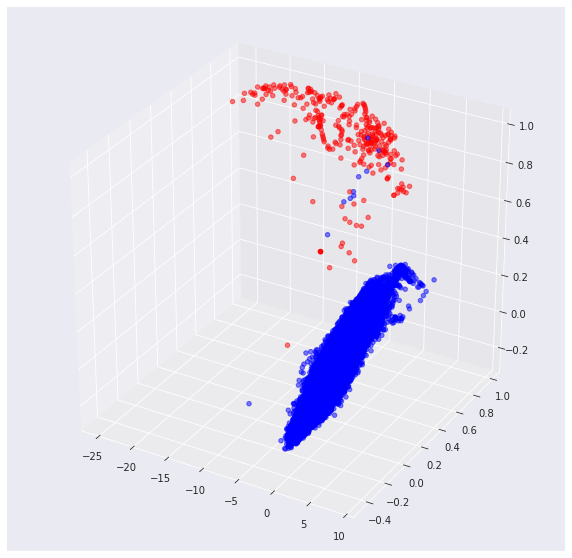


real_val


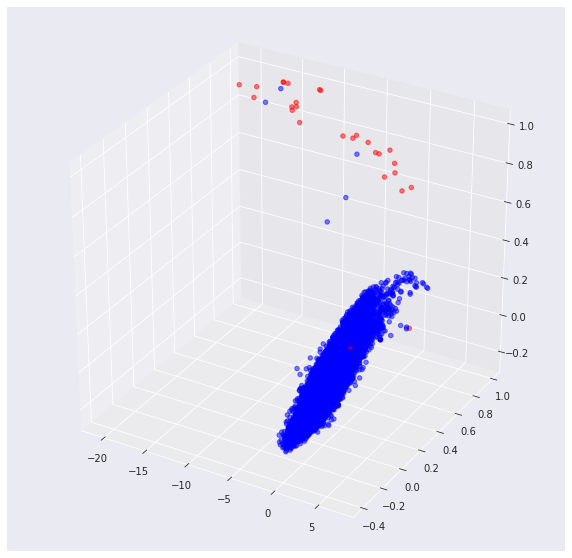

In [ ]:
# print("SVC model apply before & after")

# color_svm1 = []
# for i in range(len(test_pred1)) :
#   if test_pred1[i] == 1 :
#     color_svm1.append('r')
#   else :
#     color_svm1.append('b')

# color_svm2 = []
# for i in range(len(test_pred2)) :
#   if test_pred2[i] == 1 :
#     color_svm2.append('r')
#   else :
#     color_svm2.append('b')


# color_svm3 = []
# for i in range(len(test_pred3)) :
#   if test_pred3[i] == 1 :
#     color_svm3.append('r')
#   else :
#     color_svm3.append('b')

# color_svm4 = []
# for i in range(len(val_y)) :
#   if val_y[i] == 1 :
#     color_svm4.append('r')
#   else :
#     color_svm4.append('b')



# #use feature
# x, y, z = "V17", "V32", "V31"

# print("before")
# fig = plt.figure(figsize = (10, 10))
# ax = fig.add_subplot(projection = '3d')
# ax.scatter(test_df[x], test_df[y], test_df[z], alpha = 0.5, c = color_svm1)
# plt.show()

# print()
# print("SVC")
# fig = plt.figure(figsize = (10, 10))
# ax = fig.add_subplot(projection = '3d')
# ax.scatter(test_df[x], test_df[y], test_df[z], alpha = 0.5, c = color_svm2)
# plt.show()

# print()
# print("KNN")
# fig = plt.figure(figsize = (10, 10))
# ax = fig.add_subplot(projection = '3d')
# ax.scatter(test_df[x], test_df[y], test_df[z], alpha = 0.5, c = color_svm3)
# plt.show()

# print()
# print("real_val")
# fig = plt.figure(figsize = (10, 10))
# ax = fig.add_subplot(projection = '3d')
# ax.scatter(val_df[x], val_df[y], val_df[z], alpha = 0.5, c = color_svm4)
# plt.show()

In [ ]:
# val_p = svm.predict(val_pca)
# val_s= f1_score(val_y, val_p, average='macro')
# print(val_s)

0.9209734995691702


In [ ]:
# train_p = svm.predict(train_pca)
# train_s = f1_score(train_y, train_p, average='macro')
# print(train_s)

1.0


In [ ]:
# val_auc_score

0.9166139092102795